# Explore the effect of apodisation on fitting using a Monte Carlo approach

## Set up simulation dat and fitting basis set

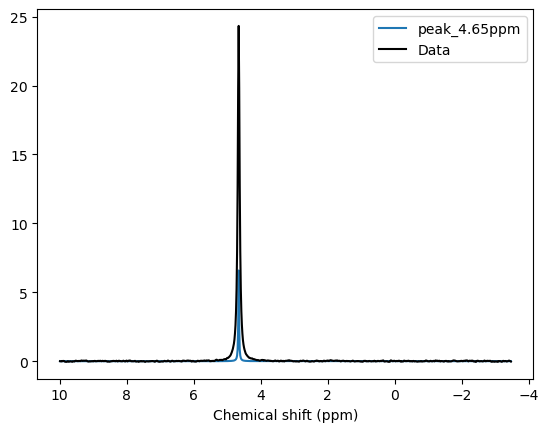

In [1]:
from scipy.linalg import circulant
import numpy as np
import matplotlib.pyplot as plt

from fsl_mrs.utils.misc import FIDToSpec
from fsl_mrs.utils.synthetic.synthetic import syntheticFID
from fsl_mrs.core import MRS, basis
from fsl_mrs.utils.preproc import apodize

npoints = 1024
noise_sd = np.sqrt(0.01)
noise_sd_single_channel = noise_sd / np.sqrt(2)
bandwidth = 2000

def make_windowed_cov(window: np.array, noise_sd: float) -> np.ndarray:
    fft_ortho_scale_factor = 1 / np.sqrt(window.size)
    scaled_fft_window = FIDToSpec(window ** 2) * noise_sd ** 2 * fft_ortho_scale_factor
    return circulant(np.fft.fftshift(scaled_fft_window))

chemical_shifts = np.asarray([4.65,]) - 4.65
basis_fid_array = []
for shift in chemical_shifts:
    FID, header = syntheticFID(
        noisecovariance=[[0]],
        chemicalshift=[shift,],
        points=npoints,
        bandwidth=bandwidth,
        linewidth=[3,]
    )
    basis_fid_array.append(FID[0])
    header['fwhm'] = 1.0


spec_basis = basis.Basis(
    np.stack(basis_fid_array),
    [f'peak_{x+4.65}ppm' for x in chemical_shifts],
    [header, ] * len(chemical_shifts))


FIDs, header = syntheticFID(
    noisecovariance=[[noise_sd_single_channel**2]],
    chemicalshift=chemical_shifts,
    points=npoints,
    bandwidth=bandwidth,
    linewidth=[5, 5],
    amplitude=[10, 10]
)

def apod_window(size: int, dwelltime: float, broadening: float) -> np.ndarray:
    taxis = np.linspace(0, dwelltime * (size - 1), size)
    Tl = 1 / broadening
    return np.exp(-taxis / Tl)

def apodise_w(data: np.ndarray, dwelltime: float, broadening: float) -> np.ndarray:
    window = apod_window(data.shape[0], dwelltime, broadening)
    return window * data, window

FID, wind = apodise_w(
    FIDs[0],
    1 / bandwidth,
    10)

dir_cov = make_windowed_cov(
    wind,
    noise_sd)

example_mrs = MRS(FID=FID, header=header, basis=spec_basis)

_ = example_mrs.plot_basis(add_spec=True, ppmlim=(-10,10))

## Fitting model

This is a simplified FSL-MRS fitting model only including concentration, shifts and a single linewidth term

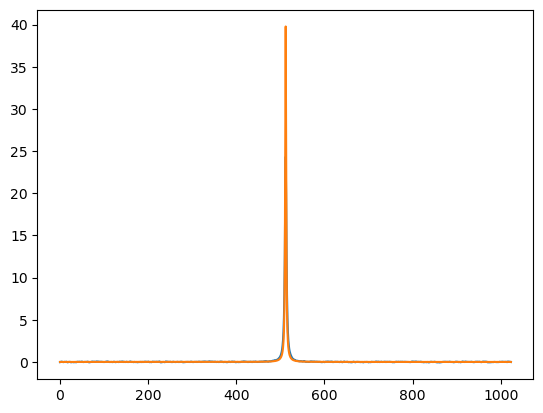

6.72333311246831e-07
4.1131021694498345e-07
5.988062935911416e-07


In [2]:
def forward_and_jac(x):
    # x is conc_1, eps, gamma
    
    exp = np.exp(-(1j * x[1] + x[2]) * header['taxis'])
    m_term = exp * spec_basis.original_basis_array.T
    Fmet = FIDToSpec(m_term, axis=1).T
    Ftmet = FIDToSpec(header['taxis'] * m_term, axis=1).T
    Ftmetc = Ftmet @ x[:1, np.newaxis]
    S = Fmet @ x[:1, np.newaxis]

    # Gradients
    dSdc = Fmet
    dSdgamma = -Ftmetc
    dSdeps = -1j * Ftmetc
    jac = np.concatenate((dSdc, dSdeps, dSdgamma), axis=1)

    return S, jac


gt = np.asarray([10, 0, (5-3)*np.pi])
S1, jac = forward_and_jac(gt)

plt.plot(FIDToSpec(FID).real)
plt.plot(S1.real)
plt.show()
eps = 1E-08

for idx in range(3):
    tmp = gt.copy()
    tmp[idx] += eps
    S2, _ = forward_and_jac(tmp)
    manual_grad = (S2[:,0] - S1[:,0]) / eps
    print(np.max(np.abs(manual_grad-jac[:, idx])))
    assert np.allclose(manual_grad, jac[:, idx], atol=1E-5)


[-0.01974025  0.0485217  -5.77395931]


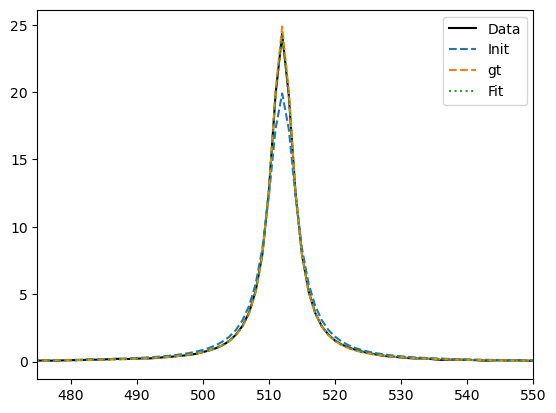

In [11]:
from scipy.optimize import minimize
def fit(fid, x0):
    spec_data = FIDToSpec(fid)

    def err_lsq(x):
        err = spec_data[:, np.newaxis] - forward_and_jac(x)[0]
        return np.real(np.sum(err * np.conj(err)))


    def grad_lsq(x):
        S, dS = forward_and_jac(x)
        Spec = spec_data[: , np.newaxis]
        return np.real(np.sum(S * np.conj(dS) + np.conj(S) * dS - np.conj(Spec) * dS - Spec * np.conj(dS), axis=0))


    xout = minimize(
        err_lsq,
        bounds=((0, None), (None, None), (0, None)),
        x0=x0,
        jac=grad_lsq
    )
    return xout.x

init = np.asarray([10, 0, (10-3)*np.pi])
gt = np.asarray([10, 0, (10-5)*np.pi])
xout = fit(FID, init)

print(xout- init)
plt.plot(FIDToSpec(FID).real, 'k', label='Data')
plt.plot(forward_and_jac(init)[0].real, '--', label='Init')
plt.plot(forward_and_jac(gt)[0].real, '--', label='gt')
plt.plot(forward_and_jac(xout)[0].real, ':', label='Fit')
plt.legend()
plt.xlim([475, 550])
plt.show()


## Define a fitting function including  whitening in the loss function

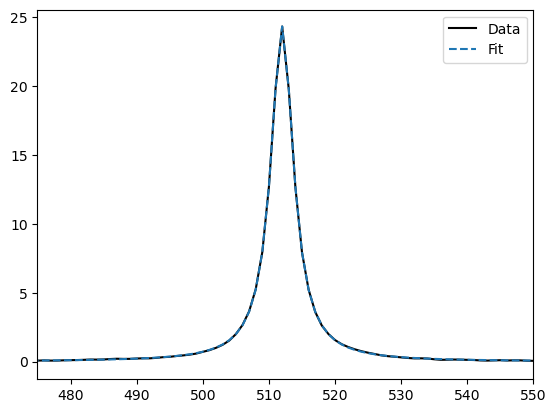

In [22]:
import numpy as np
import scipy.linalg as sla
import scipy.optimize as opt

def fit_nonlinear_complex_with_bounds(
        data: np.ndarray,
        model: callable,
        theta0: np.ndarray,
        C: np.ndarray,
        jac: callable = None,
        bounds=None,
        minimize_options: dict = None,
        method=None,
        verbose=False):
    """
    Fit nonlinear complex model m(theta) to complex data d with known covariance C,
    using scipy.optimize.minimize and supporting parameter bounds.

    Parameters
    ----------
    d : array_like, shape (N,)
        Complex data vector.
    model : callable
        model(theta) -> m (complex vector of shape (N,))
    theta0 : array_like, shape (M,)
        Initial parameter vector (real).
    C : array_like, shape (N, N)
        Known Hermitian positive-definite covariance matrix.
    jac : callable, optional
        jac(theta) -> J with shape (N, M) (complex). If given, analytic gradient is used.
    bounds : sequence or None
        Sequence of (min, max) pairs for each element in theta, or None. Matches scipy.optimize.minimize format.
    minimize_options : dict, optional
        Options passed to scipy.optimize.minimize.
    return_cov : bool
        If True, attempt to compute covariance ~ inv(J^H C^{-1} J) at solution.
    method : str or None
        Minimizer method. If None, defaults to 'L-BFGS-B' if bounds provided, else 'BFGS'.

    Returns
    -------
    Optimised theta
    """
    N = data.shape[0]
    if C.shape != (N, N):
        raise ValueError("C must be square with shape (N,N) matching data length N.")

    # choose default method
    if method is None:
        method = 'L-BFGS-B' if bounds is not None else 'BFGS'

    # Cholesky and solver
    L = sla.cholesky(C, lower=True, check_finite=False)
    cfact = sla.cho_factor(C, lower=True, check_finite=False)
    def solve_C(rhs):
        return sla.cho_solve(cfact, rhs, check_finite=False)
    def whiten(v):
        return sla.solve(L, v)

    # validate bounds shape
    if bounds is not None:
        if len(bounds) != theta0.size:
            raise ValueError("bounds must be length M = len(theta0).")

    # Objective
    def objective(theta):
        y = whiten(data - model(theta))
        return np.real(np.vdot(y, y))

    # Analytic gradient if provided
    jac_for_minimize = None
    if jac is not None:
        def grad(theta):
            m = model(theta)
            J = jac(theta)
            if J.shape != (N, theta.size):
                raise ValueError("jac(theta) must return shape (N, M).")
            Cinv_resid = solve_C(data - m)
            g_complex = -2.0 * (J.conj().T @ Cinv_resid)
            return np.real(g_complex)
        jac_for_minimize = grad

    if minimize_options is None:
        minimize_options = {}

    # call minimize with bounds
    opt_result = opt.minimize(fun=objective,
                              x0=theta0,
                              jac=jac_for_minimize,
                              method=method,
                              bounds=bounds,
                              options=minimize_options)
    if verbose:
        print(opt_result)
    
    return opt_result.x

def fwd(x):
    return forward_and_jac(x)[0][:,0]

def jac(x):
    return forward_and_jac(x)[1]

out = fit_nonlinear_complex_with_bounds(
    FIDToSpec(FID),
    fwd,
    gt,
    dir_cov,
    jac=jac,
    bounds=((0, None), (None, None), (0, None))
)
plt.plot(FIDToSpec(FID).real, 'k', label='Data')
# plt.plot(forward_and_jac(gt)[0].real)
plt.plot(forward_and_jac(out)[0].real, '--', label='Fit')
plt.xlim([475, 550])
plt.legend()
plt.show()


## Define convenience functions
To generate (apodised) FIDs + Covariance, and to run one instance of fitting

In [23]:
def make_apodised_fid(noise_sd, apod):
    if apod <= 0:
        raise ValueError('Apodisation must be > 0.')

    FIDs, _ = syntheticFID(
        noisecovariance=[[(noise_sd/np.sqrt(2))**2]],
        chemicalshift=chemical_shifts,
        points=npoints,
        bandwidth=bandwidth,
        linewidth=[5, 5],
        amplitude=[10, 10]
    )

    FID, wind = apodise_w(
            FIDs[0],
            1 / bandwidth,
            apod)

    cov = make_windowed_cov(
        wind,
        noise_sd)
    
    # Ensure symmetry of cov
    cov = (cov + cov.T) / 2
    
    return FID, cov


def mc_fitting_func(noise_sd, apod_hz):
    FID, cov = make_apodised_fid(noise_sd, apod_hz)
    
    x0 = np.asarray([10, 0, (2 + apod_hz) * np.pi])
    fitlsq = fit(FID, x0)
    fitcov = fit_nonlinear_complex_with_bounds(
        FIDToSpec(FID),
        fwd,
        x0,
        cov,
        jac=jac
    )

    return fitlsq[0], fitcov[0], FID



### Make plot of noise levels and calculate the associated SNR

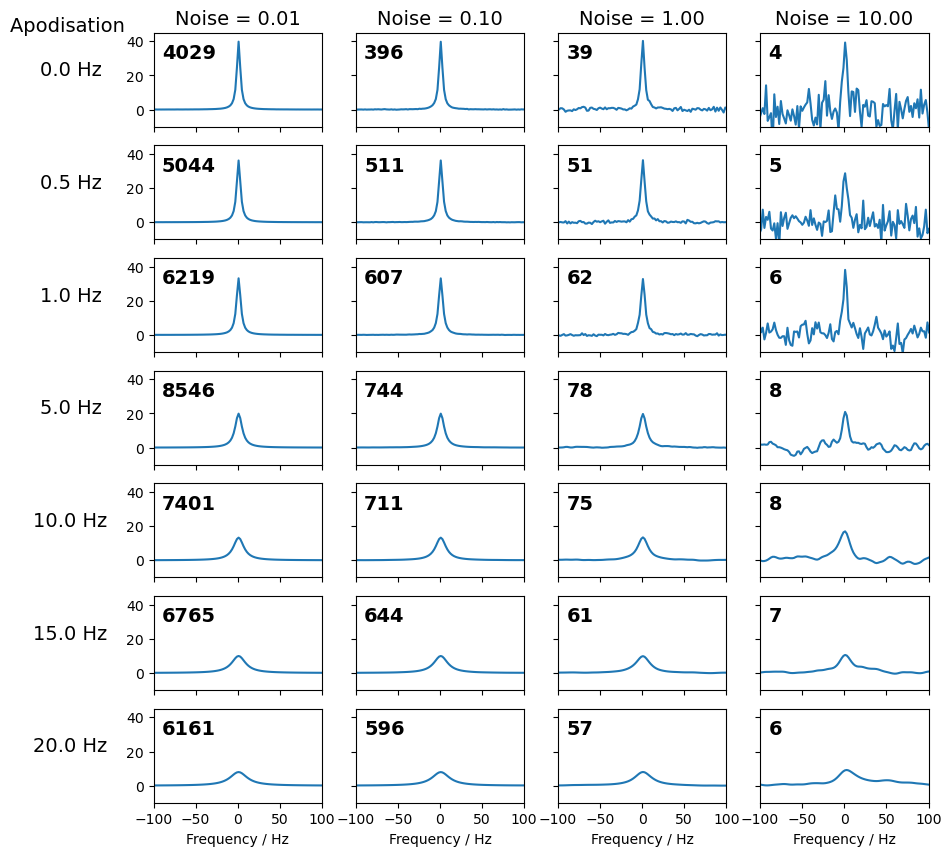

In [21]:
noise_vec = [0.01, 0.1, 1, 10]
apod_vec_hz = np.asarray([1E-15, 0.5, 1, 5, 10, 15, 20]) 
apod_vec = apod_vec_hz * np.pi

def calculate_matched_filter_snr(noise_sd, apod):
    noise_FID, _ = syntheticFID(
        noisecovariance=[[(noise_sd/np.sqrt(2))**2]],
        chemicalshift=chemical_shifts,
        points=npoints,
        bandwidth=bandwidth,
        linewidth=[5, 5],
        amplitude=[0, 0]
    )
    signal_FID, _ = syntheticFID(
        noisecovariance=[[0]],
        chemicalshift=chemical_shifts,
        points=npoints,
        bandwidth=bandwidth,
        linewidth=[5, 5],
        amplitude=[10, 10]
    )

    filtered_noise, _ = apodise_w(
            noise_FID[0],
            1 / bandwidth,
            apod)
    
    filtered_signal, _ = apodise_w(
            signal_FID[0],
            1 / bandwidth,
            apod)
    
    noise = np.std(FIDToSpec(filtered_noise))
    signal_height = np.max(FIDToSpec(filtered_signal))

    return np.round(np.real(signal_height)/noise, 0)

noise_grid, apod_grid = np.meshgrid(
    noise_vec,
    apod_vec)

fig, axes = plt.subplots(len(apod_vec), len(noise_vec), figsize=(10, 10), sharex=True, sharey=True)

snrfont = {
        'weight': 'bold',
        'size': 14,
        }

for idx, (noise, apod, ax) in enumerate(zip(noise_grid.ravel(), apod_grid.ravel(), axes.ravel())):
    snr = calculate_matched_filter_snr(noise, apod)
    example_fid, _ = make_apodised_fid(noise, apod)

    ax.plot(header['faxis'], FIDToSpec(example_fid).real)
    ax.set_xlim([-100, 100])
    ax.set_ylim([-10, 45])
    if noise == noise_vec[0] and apod == apod_vec[0]:
        ax.set_ylabel(f'Apodisation \n\n{apod / np.pi:0.1f} Hz', rotation=0, labelpad=40, fontdict={'size': 14})
    elif noise == noise_vec[0]:
        ax.set_ylabel(f'{apod / np.pi:0.1f} Hz', rotation=0, labelpad=40, fontdict={'size': 14})
    if apod == apod_vec[0]:
        ax.set_title(f'Noise = {noise:0.2f}', fontdict={'size': 14})
    elif apod == apod_vec[-1]:
        ax.set_xlabel('Frequency / Hz')
    # ax.set_ylabel(f'Noise = {noise:e}')
    ax.text(-90, 30, f'{snr:g}', fontdict=snrfont)

# plt.savefig("../figures/apodisation_spectra.png", dpi=600, bbox_inches="tight") 

## Construct plot of covariance matrix

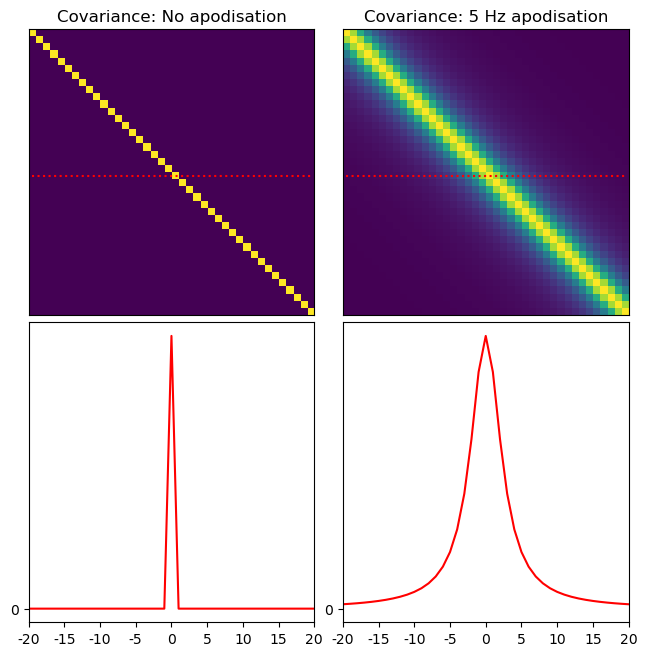

In [86]:
example_fid, example_cov = make_apodised_fid(0.01, 1E-15)
example_fid_apod, example_cov_apod = make_apodised_fid(0.01, 5*np.pi)


extract_index = 40
plot_idx = int(example_cov_apod.shape[0]/2)
fig, axes = plt.subplots(2,2, figsize=(6, 6))
axes[0,0].matshow(np.real(example_cov)[:extract_index, :extract_index])
axes[0,1].matshow(np.real(example_cov_apod)[:extract_index, :extract_index])

axes[0,0].hlines(20, 0, 39, colors='r', linestyle=':')
axes[0,1].hlines(20, 0, 39, colors='r', linestyle=':')


axes[1,0].plot(np.real(example_cov)[plot_idx, :], 'r')
axes[1,1].plot(np.real(example_cov_apod)[plot_idx, :], 'r')
axes[1,0].set_xlim([plot_idx-20, plot_idx+20])
axes[1,1].set_xlim([plot_idx-20, plot_idx+20])

for ax in axes.ravel():
    ax.set_yticks([])
for ax in axes[0]:
    ax.set_xticks([])
for ax in axes[1]:
    ax.set_xticks(np.arange(plot_idx-20, plot_idx+21, 5), np.arange(-20, 21, 5))
    ax.set_yticks([0])

axes[0,0].set_title('Covariance: No apodisation')
axes[0,1].set_title('Covariance: 5 Hz apodisation')

plt.subplots_adjust(
    top = 1,
    bottom = 0,
    right = 1,
    left = 0, 
    hspace = 0,
    wspace = 0.1)

plt.savefig("../figures/apodisation_covariance.png", dpi=600, bbox_inches="tight") 

## Run Monte Carlo

In [28]:
accumulated_param = []
accumulated_param2 = []
n_mc_reps = 2000

noise_grid, apod_grid, _ = np.meshgrid(
    noise_vec,
    apod_vec,
    np.arange(n_mc_reps)
)

for idx, (noise, apod) in enumerate(zip(noise_grid.ravel(), apod_grid.ravel())):
    param, param2, example_fid = mc_fitting_func(noise, apod_hz=apod)
    accumulated_param.append(param)
    accumulated_param2.append(param2)
    if not idx % 5000:
        print(f'{idx}/{noise_grid.size}')


res_lsq = np.asarray(accumulated_param).reshape(apod_grid.shape)
res_mle = np.asarray(accumulated_param2).reshape(apod_grid.shape)

0/56000
5000/56000
10000/56000
15000/56000
20000/56000
25000/56000
30000/56000
35000/56000
40000/56000
45000/56000
50000/56000
55000/56000


/Users/wclarke/Library/CloudStorage/OneDrive-Nexus365/projects/special_issue_fmrs/.pixi/envs/default/lib/python3.14/site-packages/scipy/optimize/_linesearch.py:89: RuntimeWarning:

overflow encountered in dot



In [29]:
rmse_mle = np.linalg.norm(res_mle-10, axis=-1)/np.sqrt(res_mle.shape[-1])
rmse_lsq = np.linalg.norm(res_lsq-10, axis=-1)/np.sqrt(res_mle.shape[-1])
# As percentage of a peak with conc = 10
rmse_mle *= 100/10
rmse_lsq *= 100/10

## Plot final bias output

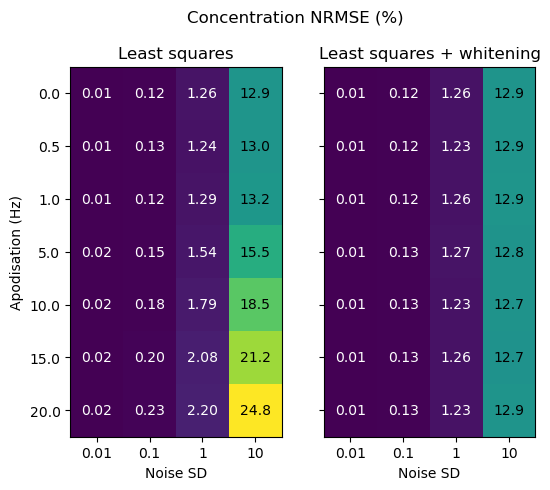

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 5), sharey=True)
ax1.imshow(rmse_lsq, vmin=0, vmax=rmse_lsq.max())
ax2.imshow(rmse_mle, vmin=0, vmax=rmse_lsq.max())


import math

def format_fixed_digits(x, total_digits):
    if x == 0:
        int_digits = 1
    else:
        int_digits = int(math.floor(math.log10(abs(x)))) + 1 if abs(x) >= 1 else 1

    decimals = max(0, total_digits - int_digits)
    return f"{x:.{decimals}f}"

for ax in (ax1, ax2):
    ax.set_xticks(range(len(noise_vec)), labels=noise_vec)
    ax.set_yticks(range(len(apod_vec)), labels=np.round(apod_vec/np.pi,1))

for idx, _ in enumerate(noise_vec):
    for jdx, _ in enumerate(apod_vec):
        colour = 'k' if rmse_lsq[jdx, idx] >= 5 else 'w'
        text = ax1.text(idx, jdx, format_fixed_digits(rmse_lsq[jdx, idx],3),
                       ha="center", va="center", color=colour)
        colour = 'k' if rmse_mle[jdx, idx] >= 5 else 'w'
        text = ax2.text(idx, jdx,format_fixed_digits(rmse_mle[jdx, idx],3),
                       ha="center", va="center", color=colour)

ax1.set_title('Least squares')
ax2.set_title('Least squares + whitening')
ax1.set_ylabel('Apodisation (Hz)')
ax1.set_xlabel('Noise SD')
ax2.set_xlabel('Noise SD')
fig.suptitle('Concentration NRMSE (%)')
plt.savefig("../figures/apodisation_bias.png", dpi=600, bbox_inches="tight") 